# Create Videos with the Azure OpenAI Sora API

This notebook demonstrates how to generate and manage videos using the Sora REST API. With Sora, you can:

- **Create engaging videos** from text prompts.
- **Generate multiple variations** to explore different visual outcomes.
- **Retrieve and track job statuses** to monitor your video generation progress.
- **Download videos and thumbnails** to your local environment.
- **Manage** your video generation jobs seamlessly.

In addition to Sora we are using the Azure OpenAI GPT-4.1 model to analyze the content of generated videos in this demo.

## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
import os
import json
import time
import pandas as pd
import threading
from IPython.display import Video, Image, Markdown

from VideoTools import Sora, VideoExtractor, VideoAnalyzer, get_video_metadata
from Instructions import use_case_prompts, filename_system_message, analyze_video_system_message

In [2]:
if not load_dotenv(find_dotenv()): raise IOError("Error: .env file could not be loaded!")

# Sora for video generation
sora_resource_name = os.getenv("SORA_AOAI_RESOURCE")
sora_deployment_name = os.getenv("SORA_DEPLOYMENT")
sora_aoai_api_key = os.getenv("SORA_AOAI_API_KEY")

sora = Sora(sora_resource_name, sora_deployment_name, sora_aoai_api_key)

# Azure OpenAI GPT-4.1 for analyzing videos and generating file names
llm_deployment = os.getenv("LLM_DEPLOYMENT")
llm_aoai_api_key = os.getenv("LLM_AOAI_API_KEY")
llm_resource_name = os.getenv("LLM_AOAI_RESOURCE")

local_video_folder = 'video-generations'

# initialize client
client = AzureOpenAI(
  azure_endpoint = f"https://{llm_resource_name}.openai.azure.com/", 
  api_key=llm_aoai_api_key,  
  api_version="2025-01-01-preview"
)

video_analyzer = VideoAnalyzer(client, llm_deployment)

The following example shows how to submit a video generation request to the Sora API using `requests`. For convenience, we've provided the `Sora` class as a simple wrapper to interact easily with the API throughout the rest of this notebook.

In [3]:
import requests

url = f"https://{sora_resource_name}.openai.azure.com/openai/v1/video/generations/jobs?api-version=preview"

headers = {
    "api-key": sora_aoai_api_key,
    "Content-Type": "application/json"
}

payload = {
    "prompt": "A Minecraft player exploring an ancient ruin at sunset.",
    "model" : sora_deployment_name,
    "n_seconds": 5,
    "height": 480,
    "width": 854,
    "n_variants": 1
}

response = requests.post(url, json=payload, headers=headers)
response.raise_for_status()

print(response.json())

{'object': 'video.generation.job', 'id': 'task_01jwdq74x1fh6vqn5ek8yyq1fs', 'status': 'queued', 'created_at': 1748512248, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'A Minecraft player exploring an ancient ruin at sunset.', 'model': 'sora', 'n_variants': 1, 'n_seconds': 5, 'height': 480, 'width': 854, 'failure_reason': None}


## Helper functions

In [4]:
def llm_completion(prompt, client, model, system_message):
    """LLM chat completion. Used for generating concise video filenames. """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_message},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            },
        ],
        response_format={"type": "json_object"},
        temperature=0.5,
    )

    return response

def check_status(job_id, polling_intervall=30):
    """Check video generation status until job is finished or failed."""
    while True:
        
        job = sora.get_video_generation_job(job_id=job_id)
        status = job['status']
        if status not in ['queued', 'preprocessing', 'running', 'processing']:
            print(f"\nJob finished with status: {status}")
            break
        time.sleep(polling_intervall)
        print('.', end='', flush=True)

def show_video_insights(video_path):
    video_extractor = VideoExtractor(video_path)
    frames = video_extractor.extract_n_video_frames(n=5)

    llm_insights = video_analyzer.video_chat(frames, system_message=analyze_video_system_message)

    display(Markdown(f"Summary:  \n{llm_insights.get('summary', '')}"))
    display(Markdown(f"Products/brands: {llm_insights.get('products', '')}"))
    display(Markdown(f"Tags: {llm_insights.get('tags', '')}"))
    display(Markdown(f"Suggestions:  \n{llm_insights.get('feedback', '')}"))


## Start Video Generation Job

- **Resolutions:** 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080

- **Max Variants per Job:** 1 to 4 depending on the resolution.

- **Duration:**  5, 10, 15, or 20s

- **Concurrency:**  max 2 pending jobs

In [5]:
prompt = use_case_prompts['Coolstuff']['Cyberpunk eye reflection']
print(prompt)

A hyper-detailed close-up of a human eye, reflecting a futuristic cyberpunk city with glowing neon lights and holograms. The eye moves slightly, blinking occasionally, while the lights in the reflection shift and flicker. The scene is cinematic, with rich textures, realistic lighting, and a sci-fi atmosphere similar to Blade Runner. The depth of field is shallow, focusing on the intricate details of the eye and the illuminated cityscape within it. The color palette includes deep blues, warm oranges, and bright neon accents, creating a mesmerizing and surreal visual effect. 4K. Frame rate: 24-30 FPS for a cinematic look.


In [6]:
job = sora.create_video_generation_job(prompt=prompt,
                                       n_seconds=10,
                                       width=854,
                                       height=480,
                                       n_variants=2)

job_id = job['id']

# poll status as background process
threading.Thread(target=check_status, args=(job_id,), daemon=True).start()

.
Job finished with status: succeeded


## Download and Analyze Videos
In addition to the Sora video generation model, we use **GPT-4.1** to:

1. Generate a concise, descriptive filename based on the original text prompt.
2. Analyze the video content to: Summarize key scenes, identify visible brands, and provide suggestions for improvement.

In [7]:
# If you want to retrieve a specific job
# job_id = "task_01jwdpp8a2ern97az3j8x8jayd"

job = sora.get_video_generation_job(job_id=job_id)

scene_summary = ""
downloaded_videos = []

for generation in job['generations']:
    if scene_summary == "":
        prompt = generation['prompt']
        result = llm_completion(prompt, client, llm_deployment, filename_system_message)
        scene_summary = json.loads(result.choices[0].message.content)['filename']

    gen_id = generation['id'] 
    filename = f"{scene_summary}_{gen_id}.mp4"

    _ = sora.get_video_generation_video_content(generation_id=gen_id, file_name=filename, target_folder=local_video_folder)
    print(f'Downloaded {filename} to folder: {local_video_folder}')
    downloaded_videos.append(filename)

Downloaded cyberpunk_eye_closeup_neon_city_reflection_cinematic_gen_01jwdq86y5fhe8pwekywnwh990.mp4 to folder: video-generations
Downloaded cyberpunk_eye_closeup_neon_city_reflection_cinematic_gen_01jwdq86ybfsztcqs2qm5e2n6y.mp4 to folder: video-generations


In [8]:
for idx, videofile in enumerate(downloaded_videos):
    print(f'Variant {idx+1}: ')
    video_path = os.path.join(local_video_folder, videofile)
    display(Video(video_path))
    show_video_insights(video_path)

Variant 1: 


Summary:  
The video presents a highly stylized, close-up visual journey centered on a human eye. The iris reflects vibrant neon cityscapes, suggesting themes of perception, technology, or urban life. The sequence includes extreme close-ups of the eye opening and closing, with the city lights remaining a constant visual motif within the reflection. The narrative appears to explore the connection between human experience and the modern, digital world.

Products/brands: No specific named brands or products are clearly identifiable in the cityscape reflections.

Tags: ['neon colors', 'night', 'close-up eye', 'urban cityscape reflection', 'futuristic mood']

Suggestions:  
The video is visually striking and effectively uses close-up shots and vibrant reflections to create a futuristic, immersive mood. To improve, consider adding more narrative context or variety in visuals to maintain viewer engagement. If the intent is to highlight a specific product or brand, ensure it is more clearly visible. Adding subtle sound design or a voiceover could also enhance the storytelling and emotional impact.

Variant 2: 


Summary:  
The video presents a visually striking sequence focused on a close-up of a human eye. Reflected in the eye is a vibrant, futuristic cityscape filled with neon-lit skyscrapers and digital billboards, suggesting themes of technology, urban life, or a cyberpunk vision of the future. The narrative appears to explore the concept of seeing or perceiving a digital or urban world through the human experience, possibly hinting at the merging of humanity and technology. The brief moment where the eye closes and reopens emphasizes the act of observation or awakening.

Products/brands: No clearly identifiable named brands or products are visible, though the cityscape features generic neon signage reminiscent of real-world advertising.

Tags: ['neon colors', 'night', 'close-up', 'futuristic cityscape', 'reflective/visionary mood']

Suggestions:  
The video is visually captivating and effectively uses the eye as a metaphor for perception and connection to a futuristic world. To improve, consider adding more narrative context or progression—such as a transition from the real world to the digital city, or subtle movement within the city reflection—to enhance storytelling. Including subtle sound design or music could also heighten immersion. If the goal is to highlight specific brands or products, ensure their logos or names are more clearly visible in the cityscape.

## Manage Video Generation Jobs

In [9]:
# list all jobs 
jobs = sora.list_video_generation_jobs(limit=50)

df = pd.DataFrame(jobs['data'])
df['duration_s'] = (df['finished_at'] - df['created_at']) 
df = df[['id', 'status', 'created_at', 'finished_at', 'duration_s', 'prompt', 'n_variants', 'n_seconds', 'height', 'width', 'failure_reason']]
display(df)

,id,status,created_at,finished_at,duration_s,prompt,n_variants,n_seconds,height,width,failure_reason
0,task_01jwdj77ztf2crmhbemdq0rn5e,succeeded,1748507009,1748507028,19,A Minecraft player exploring an ancient ruin a...,1,5,480,854,None
1,task_01jwdknm9ret7bmrj95c0q1ep5,succeeded,1748508528,1748508551,23,a mouse exploring mars.,1,5,480,854,None
2,task_01jwdkx0z4e3h9ar95byfnf361,succeeded,1748508771,1748508794,23,4 kittens on neptun,2,5,480,854,None
3,task_01jwdm90jzefjv6ddyfcdmenqt,succeeded,1748509164,1748509359,195,fashion model in paris,1,10,1920,1080,None
4,task_01jwdp0dw6fzqacrbnqbyttqw5,succeeded,1748510979,1748511186,207,"A steampunk-inspired cityscape, a woman in Vic...",1,10,1080,1920,None
5,task_01jwdpjfs3fjyvc6m9vd0r862w,succeeded,1748511571,1748511603,32,"A steampunk-inspired cityscape, a woman in Vic...",2,10,480,854,None
6,task_01jwdpp8a2ern97az3j8x8jayd,succeeded,1748511695,1748511734,39,"A steampunk-inspired cityscape, a woman in Vic...",2,10,480,854,None
7,task_01jwdq3fwdfdht64tqwvjxqacp,succeeded,1748512128,1748512169,41,"A hyper-detailed close-up of a human eye, refl...",2,10,480,854,None
8,task_01jwdq74x1fh6vqn5ek8yyq1fs,succeeded,1748512248,1748512273,25,A Minecraft player exploring an ancient ruin a...,1,5,480,854,None
9,task_01jwdq7fvqer4836efp4h5g114,succeeded,1748512259,1748512289,30,"A hyper-detailed close-up of a human eye, refl...",2,10,480,854,None


In [14]:
# retrieve a specific job

job_id = df.iloc[5]['id']
job = sora.get_video_generation_job(job_id=job_id)
display(job)

{'object': 'video.generation.job',
 'id': 'task_01jwdpjfs3fjyvc6m9vd0r862w',
 'status': 'succeeded',
 'created_at': 1748511571,
 'finished_at': 1748511603,
 'expires_at': 1748598003,
 'generations': [{'object': 'video.generation',
   'id': 'gen_01jwdpk91serxar2d3px5tr9py',
   'job_id': 'task_01jwdpjfs3fjyvc6m9vd0r862w',
   'created_at': 1748511601,
   'width': 854,
   'height': 480,
   'n_seconds': 10,
   'prompt': "A steampunk-inspired cityscape, a woman in Victorian attire adorned with a brass goggle and intricate clockwork accessories navigates cobblestone streets illuminated by gas lamps. She enters a workshop filled with whirring gears and steam-powered machinery. Close-ups capture her confident gaze. Film Shooting Details: Lighting: Utilize warm, amber tones from gas lamps and steam to create a nostalgic, industrial ambiance. Camera Angles: Employ wide shots to showcase the detailed steampunk environment and close-ups to highlight the model's attire Movement: Incorporate steady t

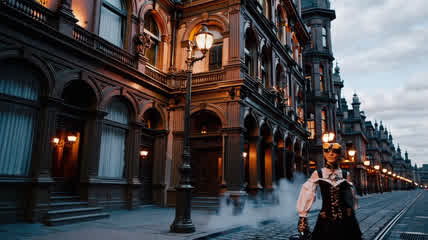

In [ ]:
# Download a thumbnail

gen_id = job['generations'][0]['id']
thumbnail_image = sora.get_video_generation_thumbnail(gen_id)
thumbnail_image.show() 

In [ ]:
# Stream a generation from a job
gen_id = job['generations'][0]['id']

stream = sora.get_video_generation_video_stream(gen_id)

video_bytes = stream.getvalue()
display(Video(data=video_bytes, embed=True, mimetype='video/mp4'))

In [ ]:
# Download a generation from a job in high quality (default)

gen_id = job['generations'][0]['id']

file_name = "my_video_high.mp4"
target_folder = "video-generations/"

file_path = sora.get_video_generation_video_content(generation_id=gen_id,
                                                    file_name=file_name,
                                                    target_folder=target_folder) 

display(Video(file_path))
print(get_video_metadata(file_path))

{'duration': 10.0, 'fps': 30.0, 'resolution': '854x480', 'bitrate_kbps': 8174.24}


In [19]:
# Download a generation from a job in low quality

gen_id = job['generations'][1]['id']

file_name = "my_video_low.mp4"
target_folder = "video-generations/"

file_path = sora.get_video_generation_video_content(generation_id=gen_id,
                                                    file_name=file_name,
                                                    target_folder=target_folder,
                                                    quality='low') 

display(Video(file_path))
print(get_video_metadata(file_path))

{'duration': 10.0, 'fps': 30.0, 'resolution': '854x480', 'bitrate_kbps': 547.67}


In [17]:
# Delete a specific job
job_id = "task_01jwdmj26pftf91na6cndb7pfs"
sora.delete_video_generation_job(job_id=job_id)


204

In [20]:
# Delete failed jobs
jobs = sora.list_video_generation_jobs(limit=50)

for job in jobs['data']:
    if job['status'] == 'failed':
        print(job)
        sora.delete_video_generation_job(job_id=job['id'])

{'object': 'video.generation.job', 'id': 'task_01jwb0abd8fxer813mp92badt9', 'status': 'failed', 'created_at': 1748421127, 'finished_at': 1748421144, 'expires_at': 1748507544, 'generations': [], 'prompt': "A steampunk-inspired cityscape, a woman in Victorian attire navigates cobblestone streets illuminated by gas lamps. She enters a workshop filled with whirring gears and steam-powered machinery. Close-ups capture her confident gaze. \nFilm Shooting Details:\nLighting: Utilize warm, amber tones from gas lamps and steam to create a nostalgic, industrial ambiance.\nCamera Angles: Employ wide shots to showcase the detailed steampunk environment and close-ups to highlight the model's attire \nMovement: Incorporate steady tracking shots to follow the model's journey through the mechanical setting, emphasizing the fusion of elegance and machinery.", 'model': 'sora-001', 'n_variants': 1, 'n_seconds': 15, 'height': 720, 'width': 1280, 'failure_reason': 'preprocessing_validation'}
